# Wifi Localization Problem Part3

* [0. Previous Preprocessing](#Preprocessing)
* [3. Predictions](#Predictions)
    * [3.1. Cascading Predictions](#Cascade)
        * [3.1.1. BuildingID](#BuildingID)
            * [3.1.1.1. Building Model Performance](#Building_Perf)
        * [3.1.2. Floor](#Floor)
            * [3.1.2.1. Floor Model Performance](#Floor_Perf)
        * [3.1.3. Latitude](#Latitude)
            * [3.1.3.1. Latitude Model Performance](#Latitude_Perf)
        * [3.1.3. Longitude](#Longitude)
            * [3.1.3.4. Longitude Model Performance](#Longitude_Perf)

In [103]:
#Load and import workspace
import dill
#dill.dump_session('notebook_session.db')
#dill.load_session('notebook_session.db')

In [104]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import scipy

#Import Models
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#Model Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Cross Validation
from sklearn.model_selection import train_test_split
from math import sqrt

In [105]:
#Import Datasets
wifi = pd.read_csv('../Datasets/trainingData.csv')
wifi_val = pd.read_csv('../Datasets/validationData.csv')
#wifi = pd.read_csv('trainingData.csv')
#wifi_val = pd.read_csv('validationData.csv')
wifi_trainval = pd.concat([wifi,wifi_val])

# <a class="anchor" id="Preprocessing"> 0. Previous Preprocessing and Feat. Engineering </a>

In [106]:
#### Ignacio: If you use so often the "preprocessing" step, you should consider to create embeed the whole process
#### inside a function to increase modularity.
#### SCALE CHANGE ####

wifi_trainval.iloc[:, 0:520] = np.where(wifi_trainval.iloc[:, 0:520] <= 0,
       wifi_trainval.iloc[:, 0:520] + 105,
       wifi_trainval.iloc[:, 0:520] - 100)


#### ORIENTATION CHANGE #####

#TRAIN
angle = np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
angle = angle/math.pi
LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
#plt.scatter(LONGITUDE,LATITUDE)
wifi["LONGITUDE"] = LONGITUDE
wifi["LATITUDE"] = LATITUDE
#MERGED
VLONGITUDE = wifi_trainval["LONGITUDE"]*np.cos(angle) +wifi_trainval["LATITUDE"]*np.sin(angle)
VLATITUDE = wifi_trainval["LATITUDE"]*np.cos(angle) - wifi_trainval["LONGITUDE"]*np.sin(angle)
wifi_trainval["LONGITUDE"] = VLONGITUDE
wifi_trainval["LATITUDE"] = VLATITUDE
#plt.scatter(VLONGITUDE,VLATITUDE)
#plt.show()

fig = px.scatter_3d(wifi_trainval, x='LONGITUDE', y='LATITUDE', z='FLOOR')
fig.show()

#### DELETE COLUMNS #####

del wifi_trainval['RELATIVEPOSITION']
del wifi_trainval['USERID']
del wifi_trainval['TIMESTAMP']

#### PROBLEMATIC PHONES #####

Phones = [5,7,8,11,12,14,17,19,21]
wifi_trainval = wifi_trainval[~wifi_trainval.PHONEID.isin(Phones)]
#Note: we need to do this before removing duplicated rows

#### DUPLICATED ROWS #####

wifi_trainval = wifi_trainval.drop_duplicates(subset=None, keep='first',inplace=False) 
#754 repeated rows removed (all from train)

#### STRANGE AND LOW SIGNALS #####

wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[1:9], 10) 
#Turn useless signals to a single useless number (10)

wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[71:106], 70) 
#Reduce perfect signals above 70 to 70.

#### NEW WAP AVERAGE COLUMN #####

#maxWAPvalue = wifi_trainval.iloc[:,0:520].max(axis=1)
#Note: this messes up the model

# <a class="anchor" id="Predictions"> 3. Predictions </a>

Two approaches make the most sense:
1. Training on the 'train set' without splitting and testing on the 'validation set'
2. Merging 'train' and 'validation set', splitting, and testing on ~30% of the data.

In this case, we are using **Approach no. 2** (merging datasets)

# Ignacio: Why do you think Approach no. 2 is better than no. 1?

## <a class="anchor" id="Cascade"> 3.1. Cascading Predictions </a>

# Ignacio: Good explanation of your approach
The order for prediction will be: first Building, then Floor, then Latitude and finally Longitude. <br>
The reasonale is the following: <br>
Building is the easiest to predict, since there's only 3 possibilities. Immediately next goes floor.
As for Latitude or Longitude, the reason is not very strong, but Latitude is kind of the 'x' axis in the world map, which defines building (after angle transformation).

In [107]:
#Making sure what number each column is
#### Ignacio: A better approach using list comprehension see:
#### https://medium.com/better-programming/list-comprehension-in-python-8895a785550b
#### https://www.programiz.com/python-programming/list-comprehension
#print(wifi_trainval.columns.get_loc('BUILDINGID'))
#print(wifi_trainval.columns.get_loc('FLOOR'))
#print(wifi_trainval.columns.get_loc('LATITUDE'))  #The 'X' coordinate
#print(wifi_trainval.columns.get_loc('LONGITUDE')) #The 'Y' coordinate
result = [(x,wifi_trainval.columns.get_loc(x)) for x in ['BUILDINGID','FLOOR','LATITUDE','LONGITUDE']]
print(result)

[('BUILDINGID', 523), ('FLOOR', 522), ('LATITUDE', 521), ('LONGITUDE', 520)]


### <a class="anchor" id="Split"> 3.1.0. Set up Labels & Split </a>

In [108]:
# Defining Train & Label
x = wifi_trainval.iloc[:,0:520]
#### Ignacio: You don't need the numpy "r_" method
y = wifi_trainval.iloc[:,520:524] 
#y = wifi_trainval.iloc[:,np.r_[520:524]] #Last number is not included
# We select the 4 columns we want to predict, and will choose one in each step

random.seed(101)
#### Ignacio: If you use the train_test_split function with "y" being a multiple variable you don't
#### how the samples are being selected in terms of "y; namely: are the building samples taken at random?
#### or are taken evenly? If this last case, this corresponds to the sampling you had originally?
#### What about the specific location of each sample in the dataset? You should know that the collected
#### samples inside each building and floor were not taken uniformly. Then this can be a problem. Therefore
#### You may want an STRATIFIED sampling of each BUILFING-FLOOR combination and, on the same time to have the
#### space as uniformly sampled as possible. To this end what you can do is:
#### Filter samples by BUILDING-FLOOR combination, and pick the same number of samples for each. Then WHITIN
#### each combination, sample uniformly LONGITUDE AND LATITUDE.
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7808, 520), (3347, 520), (7808, 4), (3347, 4))

### <a class="anchor" id="BuildingID"> 3.1.1. BuildingID </a>

### Random Forest (Classification)

In [110]:
#RANDOM FOREST
#### Ignacio: Why did you selected n_estimators=100? By computational efficiency? If so, you need to provide a benchmark table
#### reporting computational time and error metrics or a plot showing how the value of the parameter impacts the computational
#### time and the error metrics.
RF_B = RandomForestClassifier(n_estimators =100).fit(x_train,y_train['BUILDINGID'])
#### Ignacio: You can provide a confidence interval for your error metrics:
#scoring = {'Accuracy': make_scorer(accuracy_score),'Kappa': make_scorer(cohen_kappa_score)}
scores = cross_val_score(RF_B, x_train, y_train['BUILDINGID'], cv=10)
#print("Accuracy: %0.2f +/- %0.2f" % (scores.mean(), scores.std() * 2))
print("Performance of the Random Forest model in predicting the building on the Training set after CV with 10 folds:")
print("=============================================================================================================")
print("Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print("Kappa:    %0.3f +/- %0.3f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print()

#Predictions
RFpredictions_building = RF_B.predict(x_test)

#Performance Metrics (Errors)
print("Performance of the Random Forest model in predicting the building on the Test set:")
print("==================================================================================")
print("Accuracy: %0.3f" % (accuracy_score(y_test['BUILDINGID'], RFpredictions_building)))
print("Kappa:    %0.3f" % (cohen_kappa_score(y_test['BUILDINGID'], RFpredictions_building)))
print()
print(classification_report(y_test['BUILDINGID'], RFpredictions_building)) #DO NOT UNDERSTAND ALL THIS
#### Ignacio: YOY DON'T KNOW WHAT IS CLASS PRECISSION AND CLASS RECALL!!!??? PLEASE REVIEW THOSE CONCEPTS!!!
#### Ask Gabriel to send you the mushroom dathaton, and beyond your results understand them.
print()
print("Confussion Matrix for the Test Set: ")
print("====================================")
confusion_matrix(y_test['BUILDINGID'], RFpredictions_building)

Performance of the Random Forest model in predicting the building on the Training set after CV with 10 folds:
Accuracy: 0.998 +/- 0.000
Kappa:    0.998 +/- 0.000

Performance of the Random Forest model in predicting the building on the Test set:
Accuracy: 0.998
Kappa:    0.997

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      0.99      1.00       919
           2       1.00      1.00      1.00      1537

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347


Confussion Matrix for the Test Set: 


array([[ 890,    0,    1],
       [   0,  914,    5],
       [   0,    0, 1537]], dtype=int64)

In [111]:
#### Creating a function to plot the confussion matrix

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 890    0    1]
 [   0  914    5]
 [   0    0 1537]]


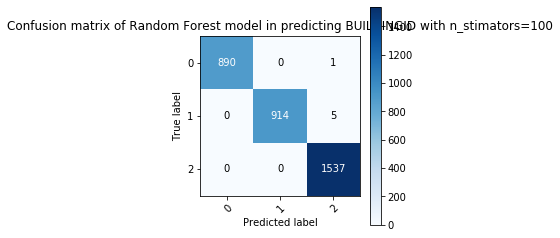

In [112]:
#### Ignacio: Plot of the non-normalized confusion matrix of the Random Forest model

#y_val_building, pred_build_Random Forest
plot_confusion_matrix(y_test['BUILDINGID'], RFpredictions_building, classes=np.array([0,1,2]),
                      normalize=False,
                      title='Confusion matrix of Random Forest model in predicting BUILDINGID with n_stimators=100')

#### Ignacio: What happened with the missclassification of the second building that was classified as the first one?
#### Is not realistic to think that the signal from the WAP reached the first building...

In [113]:
#### Ignacio: Where are those errors? Just looking the confssion matrix, we can see that the misclassifications takes place for
#### building 1, which sometimes is predicted as 0 or 2. As this building is in between other buildings, we can hypothesize that
#### the reason for this can be that sometimes the smartphone gathers signals from other buildings. Where this can happen? In the 
#### corners of the building 1 as those are the locations in which the signal strengths collected from WAPS in other buildings 
#### should be stronger.
#### Let's visualize the locations where the building ID has been misclassified by the RAndom Forest model.
#### To this end, we wil create a new dataframe with the locations, the real building id and the predicted building id.

RF_errors_test = pd.DataFrame({'LONGITUDE': y_test['LONGITUDE'],
                              'LATITUDE': y_test['LATITUDE'],
                               'FLOOR' : y_test['FLOOR'],
                              'BUILDINGID': y_test['BUILDINGID'],
                              'PRED_BUILDINGID': RFpredictions_building})
RF_errors_test['equal_build_RF'] = [x for x in np.where(RF_errors_test['PRED_BUILDINGID']==RF_errors_test['BUILDINGID'],'correct','wrong')]

#RF_errors_test['LONGITUDE'] = y_test['LONGITUDE']
#RF_errors_test['LATITUDE'] = y_test['LATITUDE']
#RF_errors_test['BUILDINGID'] = y_test['BUILDINGID']
#RF_errors_test['PRED_BUILDINGID'] = RFpredictions_building
#RF_errors_test['e_build'] = np.where(RF_errors_test['PRED_BUILDINGID']==RF_errors_test['BUILDINGID'],'correct','wrong')

In [114]:
RF_errors_test.head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,PRED_BUILDINGID,equal_build_RF
19379,-2.336809e+06,4.266894e+06,3,1,1,correct
498,-2.336707e+06,4.266868e+06,3,2,2,correct
3407,-2.336751e+06,4.266861e+06,0,1,1,correct
3803,-2.336619e+06,4.266904e+06,1,2,2,correct
10330,-2.336994e+06,4.266865e+06,1,0,0,correct


In [115]:
#### Actual plotting of misclassifications:

fig = px.scatter_3d(RF_errors_test, x='LONGITUDE', y='LATITUDE', z='FLOOR',
             color='equal_build_RF',
                    title='Location of misclassifications in predicting the building for the RF model')

fig.show()

print("It looks like our hypotheses was correct except in one case!")

It looks like our hypotheses was correct except in one case!


### Logistic Regression (Classification)

In [118]:
#DON'T FULLY UNDERSTAND THIS (or the warnings)

LR_B = LogisticRegression(
    random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train ,y_train['BUILDINGID'])

scores = cross_val_score(LR_B, x_train, y_train['BUILDINGID'], cv=10)
#print("Accuracy: %0.2f +/- %0.2f" % (scores.mean(), scores.std() * 2))
print("Performance of the Logistic Regression model in predicting the building on the Training set after CV with 10 folds:")
print("===================================================================================================================")
print("Accuracy: %0.4f +/- %0.4f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print("Kappa:    %0.4f +/- %0.4f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print()

#print(cross_val_score(LR_B, x_test, y_test['BUILDINGID'], cv=10))

#Predictions
LRpredictions_building = LR_B.predict(x_test)

#Performance Metrics (Errors)
print()
print("Confussion Matrix for the Logistic Regression on the Test Set: ")
print("===============================================================")
print("Accuracy: %0.3f" % (accuracy_score(y_test['BUILDINGID'], LRpredictions_building)))
print("Kappa:    %0.3f" % (cohen_kappa_score(y_test['BUILDINGID'], LRpredictions_building)))
print()
print(classification_report(y_test['BUILDINGID'], LRpredictions_building))
confusion_matrix(y_test['BUILDINGID'], LRpredictions_building)

Performance of the Logistic Regression model in predicting the building on the Training set after CV with 10 folds:
Accuracy: 0.9988 +/- 0.0003
Kappa:    0.9988 +/- 0.0003


Confussion Matrix for the Logistic Regression on the Test Set: 
Accuracy: 0.998
Kappa:    0.997

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      0.99      1.00       919
           2       1.00      1.00      1.00      1537

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



array([[ 890,    0,    1],
       [   0,  914,    5],
       [   0,    0, 1537]], dtype=int64)

In [119]:
LR_errors_test = pd.DataFrame({'LONGITUDE': y_test['LONGITUDE'],
                              'LATITUDE': y_test['LATITUDE'],
                               'FLOOR' : y_test['FLOOR'],
                              'BUILDINGID': y_test['BUILDINGID'],
                              'PRED_BUILDINGID': LRpredictions_building})
LR_errors_test['equal_build_LR'] = [x for x in np.where(LR_errors_test['PRED_BUILDINGID']==LR_errors_test['BUILDINGID'],'correct','wrong')]


In [120]:
LR_errors_test.head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,PRED_BUILDINGID,equal_build_LR
19379,-2.336809e+06,4.266894e+06,3,1,1,correct
498,-2.336707e+06,4.266868e+06,3,2,2,correct
3407,-2.336751e+06,4.266861e+06,0,1,1,correct
3803,-2.336619e+06,4.266904e+06,1,2,2,correct
10330,-2.336994e+06,4.266865e+06,1,0,0,correct


In [121]:
#### Actual plotting of misclassifications:

fig = px.scatter_3d(LR_errors_test, x='LONGITUDE', y='LATITUDE', z='FLOOR',
             color='equal_build_LR',
                    title='Location of misclassifications in predicting the building for the Logistic Regression model')

fig.show()

print("It looks like Logistic Regression makes misclassifications between building 1 and 2 on a different place!")

It looks like Logistic Regression makes misclassifications between building 1 and 2 on a different place!


### KNN (Classification)

In [122]:
#### Ignacio: Why did you chose to use k=1? Was this the optimal value after trying several ones? Which ones?
#### you should justify your choice of k!
KNN_B = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train['BUILDINGID'])

scores = cross_val_score(KNN_B, x_train, y_train['BUILDINGID'], cv=10)
#print("Accuracy: %0.2f +/- %0.2f" % (scores.mean(), scores.std() * 2))
print("Performance of the K-NN model in predicting the building on the Training set after CV with 10 folds:")
print("====================================================================================================")
print("Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print("Kappa:    %0.3f +/- %0.3f" % (scores.mean(), scores.std()/sqrt(10))) #The number 10 comes because you are using 10 folds.
print()


#print(cross_val_score(KNN_B, x_test, y_test['BUILDINGID'], cv=10))

#Predictions
KNNpredictions_building = KNN_B.predict(x_test)

#Performance Metrics (Errors)
print()
print("Confussion Matrix for the K-NN model on the Test Set: ")
print("======================================================")
print("Accuracy: %0.4f" % (accuracy_score(y_test['BUILDINGID'], LRpredictions_building)))
print("Kappa:    %0.4f" % (cohen_kappa_score(y_test['BUILDINGID'], LRpredictions_building)))
print()
print(classification_report(y_test['BUILDINGID'], LRpredictions_building))
confusion_matrix(y_test['BUILDINGID'], LRpredictions_building)

Performance of the K-NN model in predicting the building on the Training set after CV with 10 folds:
Accuracy: 0.998 +/- 0.000
Kappa:    0.998 +/- 0.000


Confussion Matrix for the K-NN model on the Test Set: 
Accuracy: 0.9982
Kappa:    0.9972

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      0.99      1.00       919
           2       1.00      1.00      1.00      1537

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



array([[ 890,    0,    1],
       [   0,  914,    5],
       [   0,    0, 1537]], dtype=int64)

In [123]:
KNN_errors_test = pd.DataFrame({'LONGITUDE': y_test['LONGITUDE'],
                              'LATITUDE': y_test['LATITUDE'],
                               'FLOOR' : y_test['FLOOR'],
                              'BUILDINGID': y_test['BUILDINGID'],
                              'PRED_BUILDINGID': KNNpredictions_building})
KNN_errors_test['equal_build_KNN'] = [x for x in np.where(KNN_errors_test['PRED_BUILDINGID']==KNN_errors_test['BUILDINGID'],'correct','wrong')]

In [124]:
KNN_errors_test.head()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,PRED_BUILDINGID,equal_build_KNN
19379,-2.336809e+06,4.266894e+06,3,1,1,correct
498,-2.336707e+06,4.266868e+06,3,2,2,correct
3407,-2.336751e+06,4.266861e+06,0,1,1,correct
3803,-2.336619e+06,4.266904e+06,1,2,2,correct
10330,-2.336994e+06,4.266865e+06,1,0,0,correct


In [125]:
#### Actual plotting of misclassifications:

fig = px.scatter_3d(KNN_errors_test, x='LONGITUDE', y='LATITUDE', z='FLOOR',
             color='equal_build_KNN',
                    title='Location of misclassifications in predicting the building for the K-NN model')

fig.show()


### <a class="anchor" id="Building_Perf"> 3.1.1.1 Building Model Performance </a>

In [126]:
BUILDING_Performance = [['Forest', accuracy_score(y_test['BUILDINGID'], RFpredictions_building),
                     cohen_kappa_score(y_test['BUILDINGID'], RFpredictions_building)],
                        ["Logistic Regression", accuracy_score(y_test['BUILDINGID'], LRpredictions_building),
                cohen_kappa_score(y_test['BUILDINGID'], LRpredictions_building)],
                ["KNN", accuracy_score(y_test['BUILDINGID'], KNNpredictions_building),
                cohen_kappa_score(y_test['BUILDINGID'], KNNpredictions_building)]]
                                
df_BUILDING_perf = pd.DataFrame(BUILDING_Performance, columns = ['Model', 'Accuracy','Kappa'])
df_BUILDING_perf

,Model,Accuracy,Kappa
0,Forest,0.998207,0.997210
1,Logistic Regression,0.998207,0.997210
2,KNN,0.997311,0.995814


I'm choosing Logistic Regression

#### Ignacio: Why? It has the same error metrics as the K-NN model...
#### As you can figure out, some misclassifications are made on different places. Are some places more important than others?
#### this is WHAT MATTERS! not a couple of simple numbers.

#### Are places in which all the models made misclassifications? What this is telling you? ;)
#### How you could solve this?

### <a class="anchor" id="Floor"> 3.1.2. Floor </a>

In [127]:
y_train['FLOOR'].value_counts()

3    2161
1    2054
2    1971
0    1477
4     145
Name: FLOOR, dtype: int64

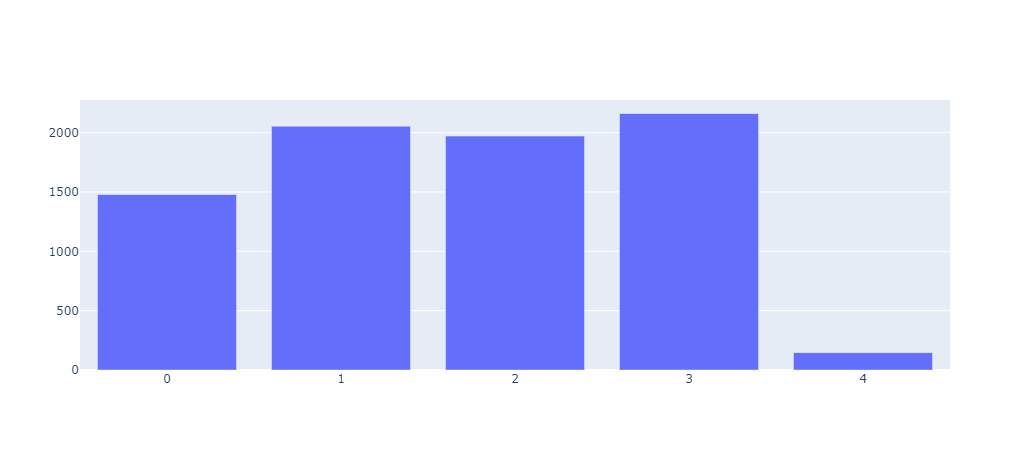

In [128]:
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='kNN', x=y_train['FLOOR'].value_counts().sort_index().index, 
           y=y_train['FLOOR'].value_counts().sort_index().values)])
## Change the bar mode

fig.show()


#### SERGI, YOU HAVE A COUPLE OF BIG PROBLEMS!!!
* How you can have so few samples on floor 4? 
* All the samples of each floor (0,1,2,3,4) belong to the same building?

#### You suffer from degeneration! The same tag can belong to different buildings. In other words, if I tell you:
#### Hey, I'm on floor 2. Can you tell me in which building am I?
#### You must fix this before attempting to predict the building. Here you have two options:
* you use the predicted building to predict the floor
* you relabel the floors in order to reflect also the building 
(in fact, if you rename the floor id in order to make it unique, if to predict the floor, then you alredy know in which
building you are)

### Random Forest (Classification)

In [ ]:
#### Ignacio: I'm not going to cover this. Fix first the problem with the floor with whaterver option you prefer.
#Creating a new column and pasting the predictions to the test
x_train['BUILDINGID'] = y_train['BUILDINGID']
x_test['BUILDINGID'] = LRpredictions_building

RF_F = RandomForestClassifier().fit(x_train,y_train['FLOOR'])
print(cross_val_score(RF_F, x_train, y_train['FLOOR'], cv=5))

#Predictions
RFpredictions_floor = RF_F.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['FLOOR'], RFpredictions_floor))
print("Kappa:", cohen_kappa_score(y_test['FLOOR'], RFpredictions_floor))
print(classification_report(y_test['FLOOR'], RFpredictions_floor)) #DO NOT UNDERSTAND THIS
confusion_matrix(y_test['FLOOR'], RFpredictions_floor)

### KNN (Classification)

In [ ]:
#### Ignacio: I'm not going to cover this. Fix first the problem with the floor with whaterver option you prefer.
#Creating a new column and pasting the predictions to the test
x_train['BUILDINGID'] = y_train['BUILDINGID']
x_test['BUILDINGID'] = LRpredictions_building

KNN_F = KNeighborsClassifier(n_neighbors=1).fit(x_train, y_train['FLOOR'])
print(cross_val_score(KNN_F, x_train, y_train['FLOOR'], cv=5))

#Predictions
KNNpredictions_floor = KNN_F.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test['FLOOR'], KNNpredictions_floor))
print("Kappa:", cohen_kappa_score(y_test['FLOOR'], KNNpredictions_floor))
print(classification_report(y_test['FLOOR'], KNNpredictions_floor)) #DO NOT UNDERSTAND THIS
confusion_matrix(y_test['FLOOR'], KNNpredictions_floor)

### <a class="anchor" id="Floor_Perf"> 3.1.2.1 Floor Model Performance </a>

In [ ]:
FLOOR_Performance = [['Forest', accuracy_score(y_test['FLOOR'], RFpredictions_floor),
                     cohen_kappa_score(y_test['FLOOR'], RFpredictions_floor)],
                ["KNN", accuracy_score(y_test['FLOOR'], KNNpredictions_floor),
                cohen_kappa_score(y_test['FLOOR'], KNNpredictions_floor)]]
                                
df_FLOOR_perf = pd.DataFrame(FLOOR_Performance, columns = ['Model','Accuracy','Kappa'])
df_FLOOR_perf

I'm choosing KNN

### <a class="anchor" id="Latitude"> 3.1.3. Latitude </a>

### Random Forest (Regression)

In [129]:
x_train['FLOOR'] = y_train['FLOOR']
x_test['FLOOR'] = KNNpredictions_floor

RF_LAT = RandomForestRegressor().fit(x_train,y_train['LATITUDE'])
print(cross_val_score(RF_LAT, x_train, y_train['LATITUDE'], cv=5))

#Predictions
RFpredictions_latitude = RF_LAT.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LATITUDE'], RFpredictions_latitude))
Rsquared = r2_score(y_test['LATITUDE'],RFpredictions_latitude)
mae = mean_absolute_error(y_test['LATITUDE'],RFpredictions_latitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE:      %.3f' % rmse)
print('MAE:       %.3f' % mae)

C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



NameError: name 'KNNpredictions_floor' is not defined

### KNN (Regression)

In [ ]:
x_train['FLOOR'] = y_train['FLOOR']
x_test['FLOOR'] = KNNpredictions_floor

KNN_LAT = KNeighborsRegressor(n_neighbors=1).fit(x_train, y_train['LATITUDE'])
print(cross_val_score(KNN_LAT, x_train, y_train['LATITUDE'], cv=5))

#Predictions
KNNpredictions_latitude = KNN_LAT.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LATITUDE'], KNNpredictions_latitude))
Rsquared = r2_score(y_test['LATITUDE'],KNNpredictions_latitude)
mae = mean_absolute_error(y_test['LATITUDE'],KNNpredictions_latitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

### <a class="anchor" id="Latitude_Perf"> 3.1.3.1 Latitude Model Performance </a>

In [ ]:
LAT_Performance = [['Forest', sqrt(mean_squared_error(y_test['LATITUDE'], RFpredictions_latitude)), 
                 r2_score(y_test['LATITUDE'],RFpredictions_latitude),
                 mean_absolute_error(y_test['LATITUDE'],RFpredictions_latitude)],
                ["KNN", sqrt(mean_squared_error(y_test['LATITUDE'], KNNpredictions_latitude)), 
                 r2_score(y_test['LATITUDE'],KNNpredictions_latitude),
                 mean_absolute_error(y_test['LATITUDE'],KNNpredictions_latitude)]]
                                
df_LAT_perf = pd.DataFrame(LAT_Performance, columns = ['Model', 'RMSE','$R^2$','MAE'])
df_LAT_perf

I'm choosing KNN, again

### <a class="anchor" id="Longitude"> 3.1.4. Longitude </a>

### Random Forest (Regression)

In [130]:
x_train['LATITUDE'] = y_train['LATITUDE']
x_test['LATITUDE'] = KNNpredictions_latitude

RF_LONG = RandomForestRegressor().fit(x_train,y_train['LONGITUDE'])
print(cross_val_score(RF_LONG, x_train, y_train['LONGITUDE'], cv=5))

#Predictions
RFpredictions_longitude = RF_LONG.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LONGITUDE'], RFpredictions_longitude))
Rsquared = r2_score(y_test['LONGITUDE'], RFpredictions_longitude)
mae = mean_absolute_error(y_test['LONGITUDE'], RFpredictions_longitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

C:\Users\Ignacio\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



NameError: name 'KNNpredictions_latitude' is not defined

In [ ]:
x_train['LATITUDE'] = y_train['LATITUDE']
x_test['LATITUDE'] = KNNpredictions_latitude

KNN_LONG = KNeighborsRegressor(n_neighbors=1).fit(x_train,y_train['LONGITUDE'])
print(cross_val_score(KNN_LONG, x_train, y_train['LONGITUDE'], cv=5))

#Predictions
KNNpredictions_longitude = KNN_LONG.predict(x_test)

#Performance Metrics (Errors)
rmse = sqrt(mean_squared_error(y_test['LONGITUDE'], KNNpredictions_longitude))
Rsquared = r2_score(y_test['LONGITUDE'],KNNpredictions_longitude)
mae = mean_absolute_error(y_test['LONGITUDE'],KNNpredictions_longitude)
print('R Squared: %.3f' % Rsquared)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

### <a class="anchor" id="Longitude_Perf"> 3.1.4.1 Longitude Model Performance </a>

In [ ]:
LONG_Performance = [['Forest', sqrt(mean_squared_error(y_test['LONGITUDE'], RFpredictions_longitude)), 
                 r2_score(y_test['LONGITUDE'],RFpredictions_longitude),
                 mean_absolute_error(y_test['LONGITUDE'],RFpredictions_longitude)],
                ["KNN", sqrt(mean_squared_error(y_test['LONGITUDE'], KNNpredictions_longitude)), 
                 r2_score(y_test['LONGITUDE'],KNNpredictions_longitude),
                 mean_absolute_error(y_test['LONGITUDE'],KNNpredictions_longitude)]]
                                
df_LONG_perf = pd.DataFrame(LONG_Performance, columns = ['Model', 'RMSE','$R^2$','MAE'])
df_LONG_perf